In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import gensim
from gensim.models import KeyedVectors
from IPython.display import clear_output
from collections import Counter
from tqdm import tqdm
import seaborn as sns

%matplotlib inline

In [2]:
from pymystem3 import Mystem
from string import punctuation

In [3]:
def read_queries(path):
    f = open(path)
    queries = []
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                tmp.append(q)
        queries.append(tmp)
    f.close()
    return queries

def read_queries_with_lemmatization(path):
    f = open(path)
    queries = []
    mystem = Mystem()
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                q_ = mystem.lemmatize(q)
                tmp.append("".join(q_).split()[0])
        queries.append(tmp)
    f.close()
    return queries

In [4]:
path = 'data/requests.uniq.train'
train = read_queries(path)
train_lem = read_queries_with_lemmatization(path)
path = 'data/requests.uniq.test'
test = read_queries(path)
test_lem = read_queries_with_lemmatization(path)
train[:5], train_lem[:5], test[:5], test_lem[:5], len(train), len(test)

([['сибирские', 'сети', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карте', 'россии'],
  ['ноофен', 'для', 'каких', 'болезней'],
  ['маус', 'хаус', 'спб']],
 [['сибирский', 'сеть', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карта', 'россия'],
  ['ноофен', 'для', 'какой', 'болезнь'],
  ['маус', 'хаус', 'спб']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикая', 'вишня'],
  ['тася', 'кривун', 'танцы', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикий', 'вишня'],
  ['тася', 'кривун', 'танец', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 51353,
 21174)

### Немного статистики по корпусу

In [18]:
to_hist_train[0][1:]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 42, 43,
       57, 68])

In [21]:
np.cumsum(to_hist_train[1][1:] * 100)

array([ 6.27032501, 21.42425954, 40.75127062, 58.5944346 , 73.28296302,
       83.58421124, 90.17584172, 94.23597453, 96.63310809, 98.05074679,
       98.88419372, 99.31260102, 99.56575078, 99.72348256, 99.81500594,
       99.85200475, 99.87147781, 99.90458201, 99.92210776, 99.9337916 ,
       99.94742274, 99.95521196, 99.95910658, 99.96105388, 99.9668958 ,
       99.96884311, 99.97079041, 99.97273772, 99.97857964, 99.98247425,
       99.98442155, 99.98831616, 99.99026347, 99.99221078, 99.99415808,
       99.99610539])

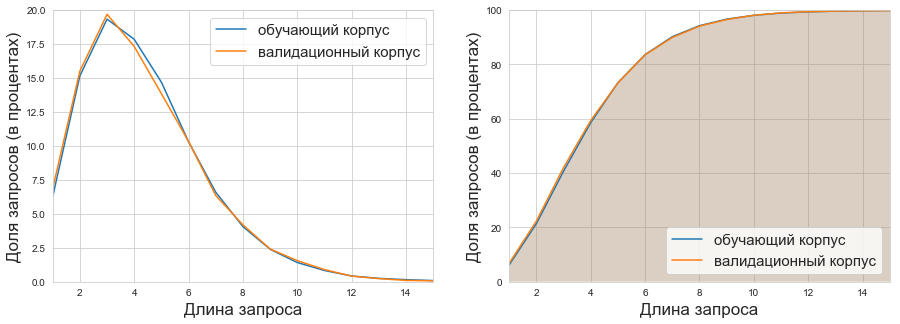

In [57]:
lens_train = list(map(len, train))
lens_test = list(map(len, test))
to_hist_train = np.unique(lens_train, return_counts=True)
to_hist_train = (to_hist_train[0], to_hist_train[1] / np.sum(to_hist_train[1]))
to_hist_test = np.unique(lens_test, return_counts=True)
to_hist_test = (to_hist_test[0], to_hist_test[1] / np.sum(to_hist_test[1]))

sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
#plt.hist(lens_train, bins=len(np.unique(lens_train)))
plt.plot(to_hist_train[0][1:], np.cumsum(to_hist_train[1][1:] * 100), label='обучающий корпус')
plt.plot(to_hist_test[0][1:], np.cumsum(to_hist_test[1][1:] * 100), label='валидационный корпус')
plt.fill_between(to_hist_train[0][1:], np.cumsum(to_hist_train[1][1:] * 100), alpha=0.2)
plt.fill_between(to_hist_test[0][1:], np.cumsum(to_hist_test[1][1:] * 100), alpha=0.2)
plt.xlim([1, 15])
plt.ylim([0, 100])
plt.xlabel("Длина запроса", fontsize=17)
plt.ylabel("Доля запросов (в процентах)", fontsize=17)
#plt.title("Зависимость доли поисковых запросов \n меньше или равной длины \n для обучающего и валидационного корпусов", fontsize=15)
plt.legend(fontsize=15)
#plt.show()

plt.subplot(1, 2, 1)
plt.plot(to_hist_train[0][1:], to_hist_train[1][1:] * 100, label='обучающий корпус')
plt.plot(to_hist_test[0][1:], to_hist_test[1][1:] * 100, label='валидационный корпус')
plt.xlim([1, 15])
plt.ylim([0, 20])
plt.xlabel("Длина запроса", fontsize=17)
plt.ylabel("Доля запросов (в процентах)", fontsize=17)
#plt.title("Зависимость доли поисковых запросов от длины \n для обучающего и валидационного корпусов", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('lengthes_statistic.png')

In [58]:
count_words_original = Counter()

for d in [train]:
    for q in d:
        for word in q:
            count_words_original[word] += 1
        
freq, counts = np.unique(np.array(list(count_words_original.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.17574006, 0.24519813, 0.29055625, 0.32405664, 0.35185578,
        0.37601319, 0.39457541, 0.41182944, 0.42762059, 0.4410561 ]))

In [75]:
count = 0
s = 0
for sent in test:
    for word in sent:
        count += 1
        if word in count_words_original.keys() and count_words_original[word] >= 3:
            s += 1
s / count * 100

70.33475284351248

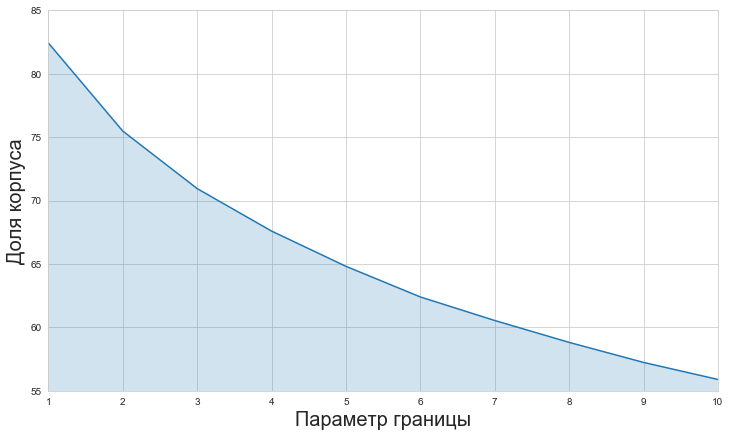

In [69]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
#plt.hist(lens_train, bins=len(np.unique(lens_train)))
plt.plot(np.arange(1, len(p)+1)[:10], (1.0 - p[:10]) * 100)
plt.fill_between(np.arange(1, len(p)+1)[:10], (1.0 - p[:10]) * 100, alpha=0.2)
plt.xlim([1, 10])
plt.ylim([55, 85])
plt.xlabel("Параметр границы", fontsize=20)
plt.ylabel("Доля корпуса", fontsize=20)
#plt.show()
plt.savefig('lex_statistic.png')

In [240]:
count_words = Counter()

for d in [train_lem]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.12185658, 0.16966756, 0.20326518, 0.23018925, 0.2515358 ,
        0.27062838, 0.28792218, 0.30358516, 0.31885922, 0.32964299]))

In [80]:
emb_2 = KeyedVectors.load_word2vec_format("ft_native_300_ru_wiki_lenta_lower_case.vec")

In [81]:
emb = KeyedVectors.load_word2vec_format("wiki.ru.vec")

In [82]:
emb_1 = KeyedVectors.load_word2vec_format("cc.ru.300.vec")

## Графики

In [83]:
def approximate_pad(data):
    to_pad = 0
    all_ = 0
    for x in data:
        for word in x:
            all_ += 1
            if word not in word_to_ind.keys():
                to_pad += 1
    return to_pad / all_

#pad_train = approximate_pad(train)
#pad_test = approximate_pad(test)
#pad_train, pad_test

In [84]:
train_st = dict()
test_st = dict()
train_pad = dict()
test_pad = dict()

for lm in ['', '_no']:
    if lm == '_no':
        count_words = Counter()

        for d in [train]:
            for q in d:
                for word in q:
                    count_words[word] += 1
    else:
        count_words = Counter()

        for d in [train_lem]:
            for q in d:
                for word in q:
                    count_words[word] += 1
    
    
    for num in ['', '_1', '_2']:
        path = 'emb' + num + lm + '_lemmatization.txt'
        f = open(path, 'r')
        count = 0
        i = -1
        tmp = []
        for line in f:
            if count==0:
                count = int(line.split()[0])
                i += 1
                if i == 5:
                    train_st[path] = tmp
                tmp = []
            else:
                count -= 1
                y = float(line.split()[0])
                tmp.append(y)
        test_st[path] = tmp
        
        if num == '':
            ind_to_word, word_to_ind = construct_vocab(emb, count_words)
        if num == '_1':
            ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
        if num == '_2':
            ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
        
        if lm == '_no':
            train_pad[path] = approximate_pad(train)
            test_pad[path] = approximate_pad(test)
        else:
            train_pad[path] = approximate_pad(train_lem)
            test_pad[path] = approximate_pad(test_lem)
                
        f.close()

In [85]:
for num in ['', '_1', '_2']:
    for lm in ['', '_no']:
        path = 'emb' + num + lm + '_lemmatization.txt'
        print(path, train_pad[path], test_pad[path])

emb_lemmatization.txt 0.22783803134363978 0.26150611826855696
emb_no_lemmatization.txt 0.3014991205041853 0.34950137458897096
emb_1_lemmatization.txt 0.19633970636330692 0.2258530537437335
emb_1_no_lemmatization.txt 0.26651374930391664 0.31058163980378417
emb_2_lemmatization.txt 0.17827689533557847 0.2135302679100857
emb_2_no_lemmatization.txt 0.2518495929569622 0.30184895692954555


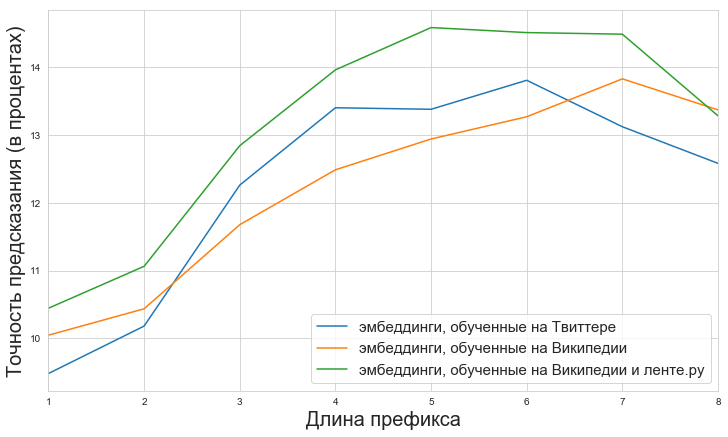

In [99]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 8) + 1
bound = len(grid)

path = 'emb' + '_no_lemmatization.txt'
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="эмбеддинги, обученные на Твиттере")
path = 'emb_1' + '_no_lemmatization.txt'
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="эмбеддинги, обученные на Википедии")
path = 'emb_2' + '_no_lemmatization.txt'
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="эмбеддинги, обученные на Википедии и ленте.ру")

plt.xlabel("Длина префикса", fontsize=20)
plt.xlim([1, 8])
#plt.ylim([10, 15.5])
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
#plt.title("Валидационный корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("valid_emb.png")

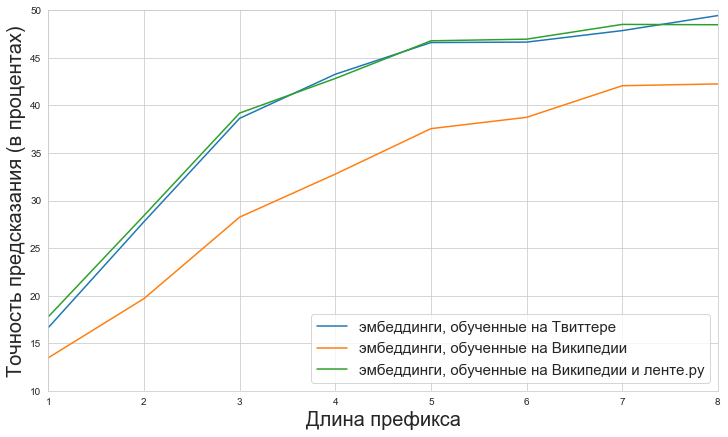

In [104]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 8) + 1
bound = len(grid)

path = 'emb' + '_no_lemmatization.txt'
plt.plot(grid, 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path]), 
         label="эмбеддинги, обученные на Твиттере")
path = 'emb_1' + '_no_lemmatization.txt'
plt.plot(grid, 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path]), 
         label="эмбеддинги, обученные на Википедии")
path = 'emb_2' + '_no_lemmatization.txt'
plt.plot(grid, 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path]), 
         label="эмбеддинги, обученные на Википедии и ленте.ру")

plt.xlabel("Длина префикса", fontsize=20)
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
plt.xlim([1, 8])
plt.ylim([10, 50])
#plt.title("Обучающий корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("train_emb.png")

In [108]:
path = 'emb_2' + '_no_lemmatization.txt'
path_2 = 'emb_2' + '_lemmatization.txt'
np.mean(100*np.array(test_st[path][:bound]) - 100*np.array(test_st[path_2][:bound]))

1.5035954132193166